In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm

import src.utils as utils

plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)
mpl.rcParams['lines.linewidth'] = 2

data_list1 = [
    os.path.join("/home/schiavazza/data/hpe/fault_button/osai/fault_button", "s1_v1"),
    os.path.join("/home/schiavazza/data/hpe/fault_button/osai/fault_button", "s1_v2"),
    os.path.join("/home/schiavazza/data/hpe/fault_button/osai/fault_button", "s2_v1"),
    os.path.join("/home/schiavazza/data/hpe/fault_button/osai/fault_button", "s2_v2")
]
data_list2 = [
    os.path.join("/home/schiavazza/data/hpe/fault_button/april_exp/binary/long", "button1"),
    os.path.join("/home/schiavazza/data/hpe/fault_button/april_exp/binary/long", "button2"),
    os.path.join("/home/schiavazza/data/hpe/fault_button/april_exp/binary/long", "button3"),
    os.path.join("/home/schiavazza/data/hpe/fault_button/april_exp/binary/long", "button4")
]
data_list3 = [
    f"/home/schiavazza/data/hpe/fault_button/APRIL/exp01/data",
    f"/home/schiavazza/data/hpe/fault_button/APRIL/exp02/data",
    f"/home/schiavazza/data/hpe/fault_button/APRIL/exp03/data",
]

In [2]:
# plotter = utils.Plotter("/home/schiavazza/data/hpe/fault_button/osai_combined/leftdvs")
plotter = utils.Plotter(data_list1[0])

rates, times = plotter.get_hist(scale=1.0)

importIitYarp trying path: /home/schiavazza/data/hpe/fault_button/osai/fault_button/s1_v1
Examining info.log: /home/schiavazza/data/hpe/fault_button/osai/fault_button/s1_v1/info.log
[552, 277]
Radius in px: 186


In [3]:
# get the maximum rates around actual button presses

press_times = plotter.press_timing[:, 0]
trigger_rates = []
trigger_times = []

for i, pt in enumerate(press_times):
    id_start = np.searchsorted(times, pt -1.0)
    id_end = np.searchsorted(times, pt)

    tmp_rates = rates[id_start:id_end]
    tmp_rates = np.sort(tmp_rates)
    id_start = int(len(tmp_rates)  * (7/8))
    tmp_rates = tmp_rates[id_start:]
    # tmp_rates = [tmp_rates[id_start:].max()]
    for r in tmp_rates:
        trigger_rates.append(r)
        trigger_times.append(pt)

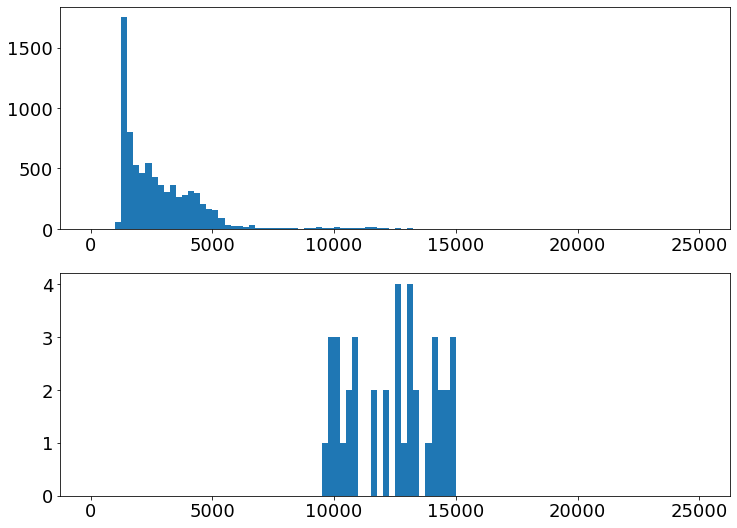

In [4]:
fig, axs = plt.subplots(2,1, figsize=(12, 9))

axs[0].hist(rates, 100, range=(0, 25000));
axs[1].hist(trigger_rates, 100, range=(0, 25000));

In [13]:
std_total_rate = np.zeros(rates.shape)
mean_total_rate = np.zeros(rates.shape)

for i in range(1, rates.shape[0]):
    std_total_rate[i] = np.std(rates[:i])
    mean_total_rate[i] = np.mean(rates[:i])

In [7]:
mean_trigger_rate = np.zeros(times[:-1].shape)
std_trigger_rate = np.zeros(times[:-1].shape)

for i, t in enumerate(times[:-1]):
    idx = np.searchsorted(trigger_times, t)

    mean_trigger_rate[i] = np.mean(trigger_rates[:idx])
    std_trigger_rate[i] = np.std(trigger_rates[:idx])

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/lib/python3/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
def findIntersection(m1,m2,std1,std2):
  a = 1/(2*std1**2) - 1/(2*std2**2)
  b = m2/(std2**2) - m1/(std1**2)
  c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
  return np.roots([a,b,c])

thresh_hist = []
trigger_hist = []

for i, t in enumerate(times[:-1]):

    trigger_mean = mean_trigger_rate[i] if ~np.isnan(mean_trigger_rate[i]) and mean_trigger_rate[i] > 0 else 0
    trigger_std = std_trigger_rate[i] if ~np.isnan(std_trigger_rate[i]) and std_trigger_rate[i] > 0 else 100

    total_mean = mean_total_rate[i]
    total_std = std_total_rate[i] if ~np.isnan(std_total_rate[i]) and std_total_rate[i] > 0 else 1

    x = findIntersection(trigger_mean, total_mean, trigger_std, total_std)

    if x.size > 1:
      x = x[x > 0]
      x = x[x < rates.max()]
      if x.size == 0:
        x = [0]
      else:
         x = [x.min()]

    thresh_hist.append(x[0])

thresh_hist = np.array(thresh_hist)


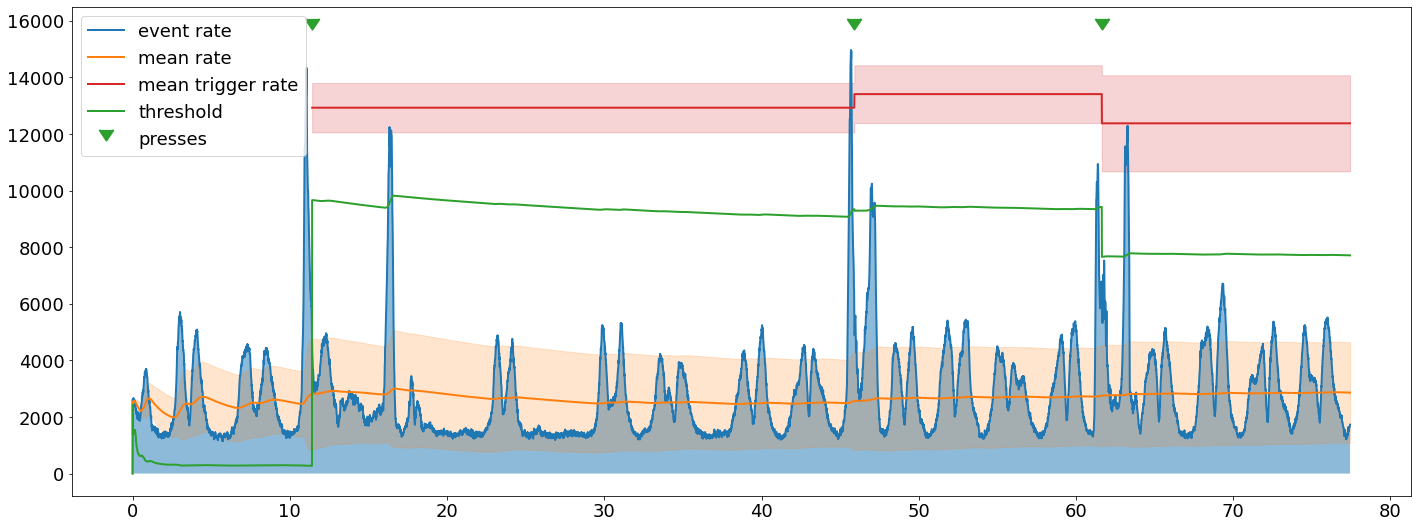

In [9]:
plt.figure(figsize=(24, 9))
plt.plot(times[:-1], rates, label="event rate")
plt.fill_between(times[:-1], rates, alpha=0.5)

plt.plot(times[:-1], mean_total_rate, color="C1", label="mean rate")
plt.fill_between(times[:-1], mean_total_rate-std_total_rate, mean_total_rate+std_total_rate, alpha=0.2, color="C1")

plt.plot(times[:-1], mean_trigger_rate, color="C3", label="mean trigger rate")
plt.fill_between(times[:-1], mean_trigger_rate-std_trigger_rate, mean_trigger_rate+std_trigger_rate, alpha=0.2, color="C3")

# plt.plot(press_times, max_rates, linestyle='--', c='C2')

plt.plot(times[:-1], thresh_hist, color="C2", label="threshold")
plt_y_lim = plt.ylim()
v = plt_y_lim[1]
plt.scatter(plotter.press_timing[:, 0], [v for x in plotter.press_timing[:, 0]], marker=7, s=200, c="C2", label="presses")

plt.legend(fontsize=18, loc="upper left")


In [10]:
print(thresh_hist[-1] / 0.01 / plotter.window_size)
print(12 * plotter.window_size)

9.005233767164977
1027392


In [11]:
i = -1
trigger_mean = mean_trigger_rate[i] if ~np.isnan(mean_trigger_rate[i]) and mean_trigger_rate[i] > 0 else 0
trigger_std = std_trigger_rate[i] if ~np.isnan(std_trigger_rate[i]) and std_trigger_rate[i] > 0 else 100

total_mean = mean_total_rate[i]
total_std = std_total_rate[i] if ~np.isnan(std_total_rate[i]) and std_total_rate[i] > 0 else 1

x = findIntersection(trigger_mean, total_mean, trigger_std, total_std)

print(x)

if x.size > 1:
    x = x[x > 0]
    x = x[x < rates.max()]
    if x.size == 0:
        x = [0]
    else:
        x = [x.min()]
    print(x)

[219510.56533254   7709.9209421 ]
[7709.920942095968]


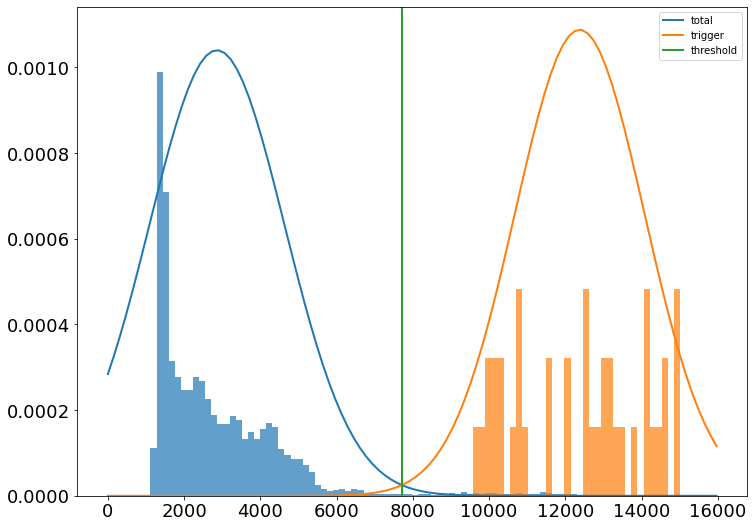

In [12]:
from scipy.stats import norm

fig = plt.figure(figsize=(12, 9))

ranges= (0, rates.max() + 1000)

plt.hist(rates, 100, range=ranges, density=True, alpha=0.7);
plt.hist(trigger_rates, 100, range=ranges, density=True, alpha=0.7);

x_axis = np.linspace(ranges[0], ranges[1], 100)

plt_y_lim = plt.ylim()
v = plt_y_lim[1]

total_scale = v / norm.pdf(x_axis, total_mean, total_std)[np.searchsorted(x_axis, total_mean)]
# trigger_scale = v / norm.pdf(x_axis, trigger_mean, trigger_std)[np.searchsorted(x_axis, trigger_mean)]

plt.plot(x_axis, norm.pdf(x_axis, total_mean, total_std) * total_scale, label="total", c="C0")
plt.plot(x_axis, norm.pdf(x_axis, trigger_mean, trigger_std) * total_scale, label="trigger", c="C1")

plt.axvline(x[0], c="C2", label="threshold")

plt.legend()